In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import norm
import tqdm
import time

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error , mean_squared_error

np.random.seed(42)

In [123]:
# method to reshape so that we don't write that again and again
def reshape(x: pd.Series) -> np.ndarray:
    return x.values.reshape(-1,1)

In [124]:
train = [pd.read_csv(f'./2B-dataset/train_set_{x}.csv') for x in ['A', 'B', 'C']]
test = [pd.read_csv(f'./2B-dataset/test_set_{x}.csv') for x in ['A', 'B', 'C']]

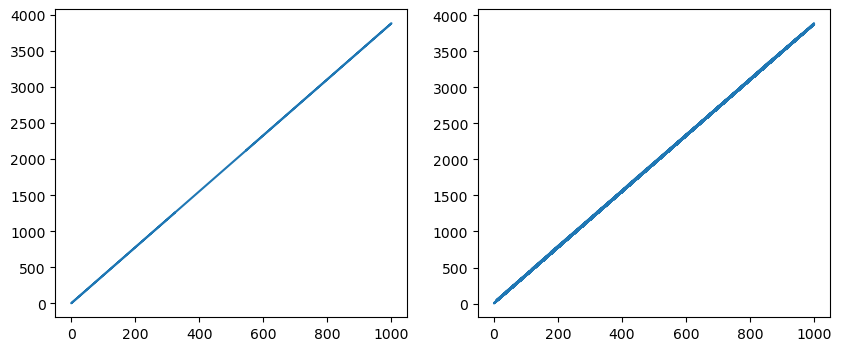

In [125]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(train[0].x, train[0].y)
plt.subplot(1,2,2)
plt.plot(test[0].x, test[0].y)

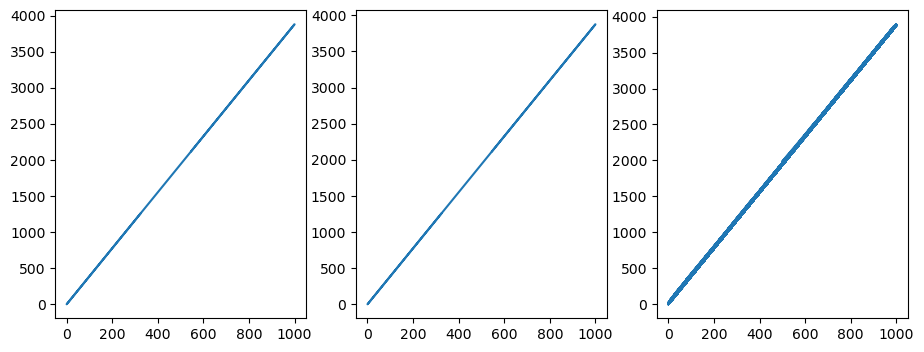

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(11, 4))
for i in range(3):
    axes[i].plot(train[i].x, train[i].y)

In [127]:
X = train[0].x.values
X.reshape(-1,1).shape

(100000, 1)

In [128]:
reg = [LinearRegression(n_jobs=-1) for _ in range(3)]

for i in range(3):
    reg[i].fit(reshape(train[i].x), reshape(train[i].y))

In [129]:
for i in range(3):
    print(i, reg[i].coef_, reg[i].intercept_)

0 [[3.87690246]] [1.59928255]
1 [[3.8769]] [-6.82121026e-13]
2 [[3.87691727]] [3.96302162]


In [130]:
# error term by y_pred - a * x - b

for i in range(3):
    train[i]['error'] = train[i].y - reg[i].coef_[0] * train[i].x - reg[i].intercept_

In [131]:
for i in range(3):
    mse = mean_squared_error(train[i].y, train[i].error)
    mae = mean_absolute_error(train[i].y, train[i].error)
    print(i, mae, mse)

0 1947.3119691099018 5043882.595597386
1 1945.7114496596207 5037650.144272449
2 1949.68313834488 5053132.591569721


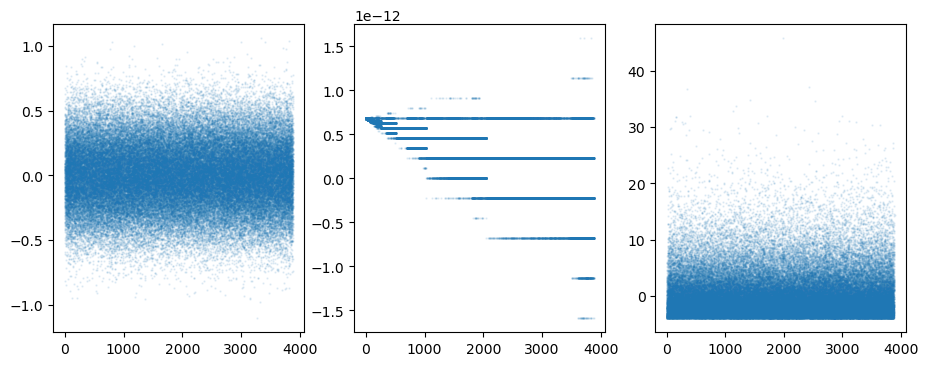

In [151]:
fig, axes = plt.subplots(1,3, figsize=(11,4))

for i in range(3):
    axes[i].scatter(train[i].y, train[i].error, alpha=0.1, s=0.5)

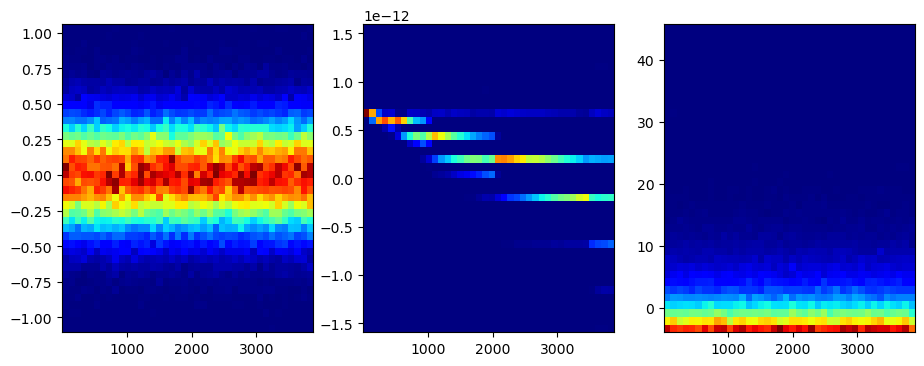

In [133]:
fig, axes = plt.subplots(1,3, figsize=(11,4))

for i in range(3):
    axes[i].hist2d(train[i].y, train[i].error, (40, 40), cmap='jet')

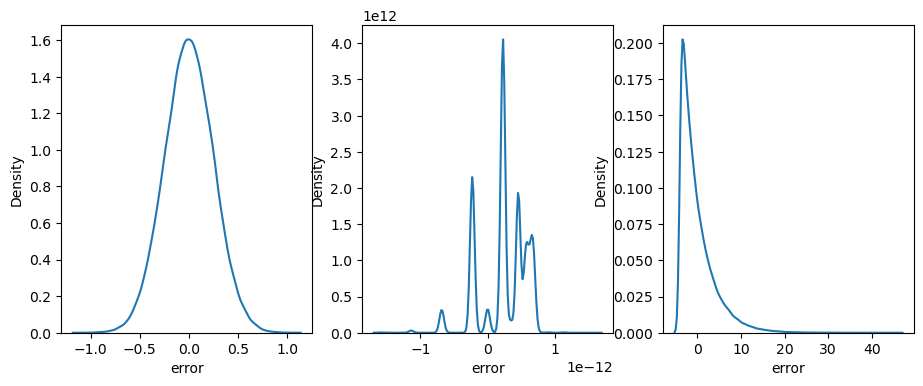

In [134]:
fig, axes = plt.subplots(1,3, figsize=(11,4))

for i in range(3):
    sns.kdeplot(train[i], x='error', ax=axes[i])

the error in training set A is likely from guassian distribution
error in C is likely from exponential distribution

In [135]:
for i in range(3):
    test[i]['error'] = test[i].y - reg[i].coef_[0] * test[i].x - reg[i].intercept_

In [136]:
for i in range(3):
    mse = mean_squared_error(test[i].y, test[i].error)
    mae = mean_absolute_error(test[i].y, test[i].error)
    print(i, mae, mse)

0 1943.393755620297 5050585.82422067
1 1941.7932386608404 5044365.897018204
2 1945.7649098926358 5059817.348097435


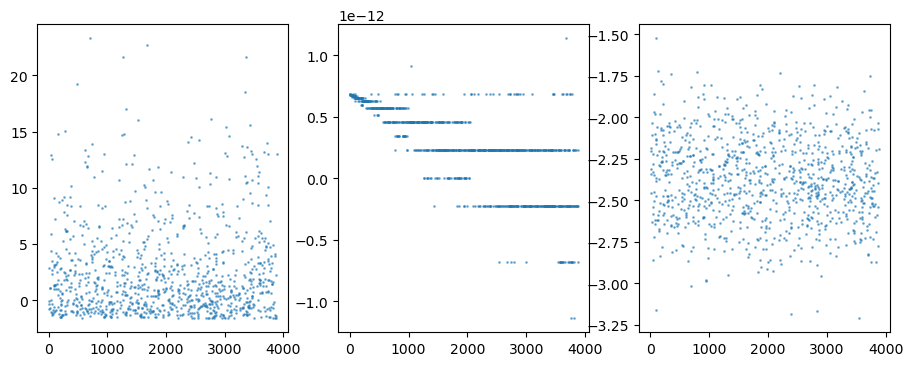

In [155]:
fig, axes = plt.subplots(1,3, figsize=(11,4))

for i in range(3):
    axes[i].scatter(test[i].y, test[i].error, alpha=0.5, s=1)

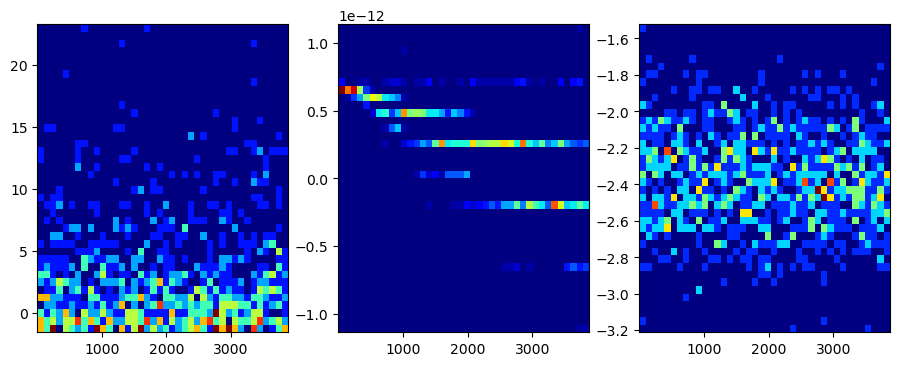

In [138]:
fig, axes = plt.subplots(1,3, figsize=(11,4))

for i in range(3):
    axes[i].hist2d(test[i].y, test[i].error, (40, 40), cmap='jet')

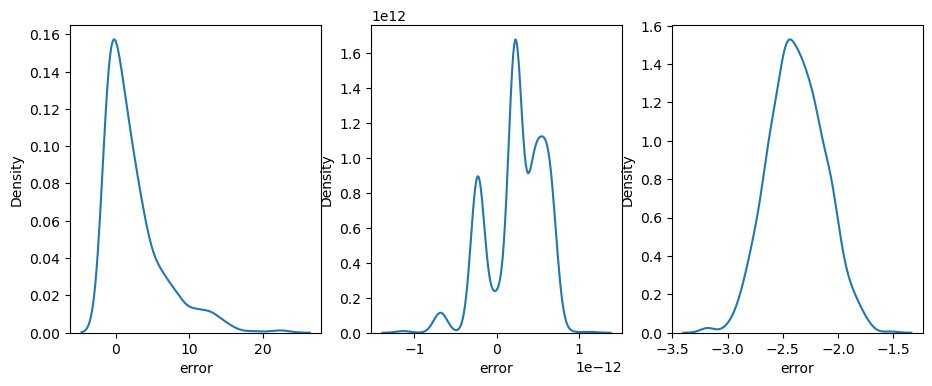

In [139]:
fig, axes = plt.subplots(1,3, figsize=(11,4))

for i in range(3):
    sns.kdeplot(test[i], x='error', ax=axes[i])

here A resembles exp dist and C resembles guassian

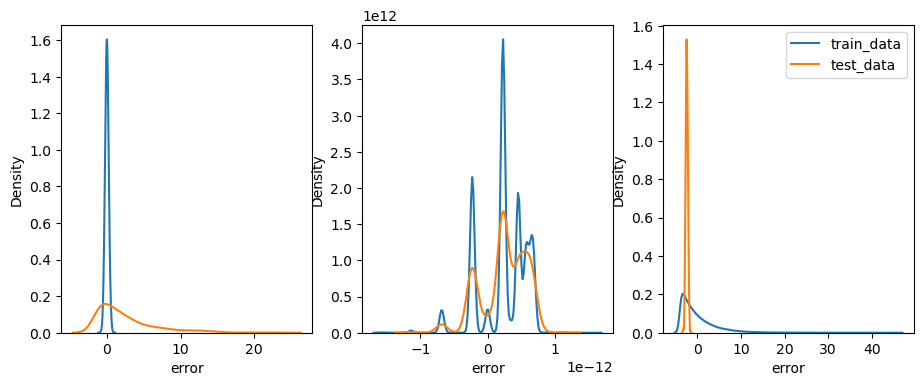

In [140]:
fig, axes = plt.subplots(1,3, figsize=(11,4))

for i in range(3):
    sns.kdeplot(train[i], x='error', ax=axes[i], label='train_data')
    sns.kdeplot(test[i], x='error', ax=axes[i], label='test_data')

plt.legend()

it can be concluded that the set B is from the actual distribution as the error term in both train and test data is consistently distributed \
also the fact that the error term in B is the minimum with the error being in the order of 1e-12 strengthens the hypothesis

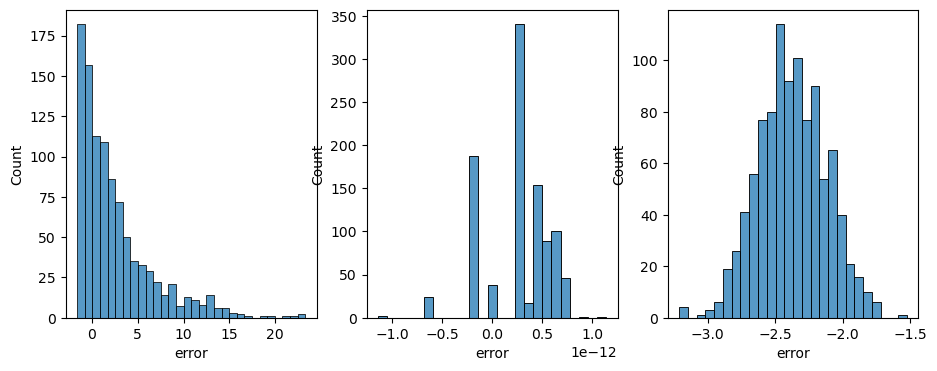

In [141]:
fig, axes = plt.subplots(1,3, figsize=(11,4))

for i in range(3):
    sns.histplot(test[i], x='error', ax=axes[i])

error term in test_A is approx exponential

$$ f(x) = \frac{1}{\theta} e^{-\frac{x}{\theta}} $$
from MLE we know that $$ \theta_{MLE} = \bar{x}  $$


In [142]:
# exp parameters of A's error dist
# but we need to make sure that all data have error > 0

test[0].error.describe()

count    1000.000000
mean        2.471923
std         4.020381
min        -1.596484
25%        -0.413482
50%         1.229794
75%         3.873647
max        23.285666
Name: error, dtype: float64

In [143]:
exp_data = test[0].error - test[0].error.min()

In [144]:
theta_mle = exp_data.mean()
print(f'{theta_mle:.2f}')

4.07


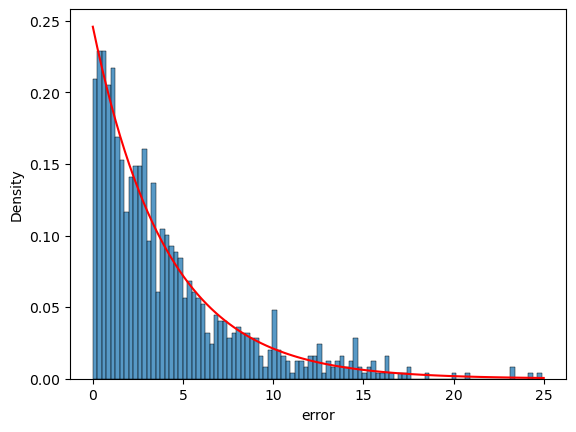

In [145]:
sns.histplot(exp_data, bins=100, stat='density')

x_error_exp = np.linspace(0, 25, 100)
plt.plot(x_error_exp, np.exp(-x_error_exp/theta_mle)/theta_mle, color='red')

In [146]:
test[2].error.describe()

count    1000.000000
mean       -2.374282
std         0.250285
min        -3.211892
25%        -2.541861
50%        -2.378567
75%        -2.204513
max        -1.523240
Name: error, dtype: float64

hence for test_C
$$ error \sim N(-2.37, 0.25) $$

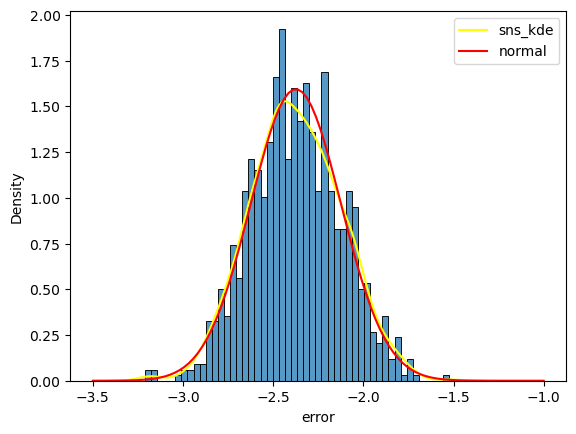

In [147]:
sns.histplot(test[2].error,bins=50, stat='density')
sns.kdeplot(test[2].error, color='yellow', label='sns_kde')

x_error_norm = np.linspace(-3.5, -1, 100)
plt.plot(x_error_norm, norm.pdf(x_error_norm, loc=test[2].error.mean(), scale=test[2].error.std()), color='red', label='normal')
plt.legend()